In [ ]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install scikit-learn==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [ ]:
!wget --no-check-certificate 'https://drive.google.com/file/d/1ldXHEO7db0jNDtIAa4NcndCdb6of7sbX/view?ts=6399fae5' -O CLARIN_EMO2.zip

--2023-01-23 09:52:26--  https://docs.google.com/uc?export=download&id=1DnWM738JjnBChtC3ln6x6-azC9lHoOmG
Resolving docs.google.com (docs.google.com)... 64.233.188.138, 64.233.188.102, 64.233.188.101, ...
Connecting to docs.google.com (docs.google.com)|64.233.188.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/njgn0qnmlr9luh8inob6tddf4ffj8rc5/1674467550000/10304474608156724863/*/1DnWM738JjnBChtC3ln6x6-azC9lHoOmG?e=download&uuid=d377a16d-12df-44ad-ad2e-d300a4d8bfff [following]
--2023-01-23 09:52:38--  https://doc-00-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/njgn0qnmlr9luh8inob6tddf4ffj8rc5/1674467550000/10304474608156724863/*/1DnWM738JjnBChtC3ln6x6-azC9lHoOmG?e=download&uuid=d377a16d-12df-44ad-ad2e-d300a4d8bfff
Resolving doc-00-2c-docs.googleusercontent.com (doc-00-2c-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:

In [ ]:
!unzip CLARIN_EMO2.zip -d ./data 

Archive:  CLARIN_EMO2.zip
  inflating: ./data/PolEmo emocje zdania Paweł.xlsx  
  inflating: ./data/PolEmo emocje zdania Ewa.xlsx  
  inflating: ./data/PolEmo emocje zdania Kamil.xlsx  
  inflating: ./data/PolEmo emocje zdania Mateusz.xlsx  
  inflating: ./data/PolEmo emocje zdania Emilia.xlsx  
  inflating: ./data/PolEmo emocje zdania Roksana.xlsx  
  inflating: ./data/PolEmo emocje zdania Gabriela.xlsx  
  inflating: ./data/PolEmo emocje zdania Ada.xlsx  


In [ ]:
!rm 'data/''PolEmo emocje zdania Ewa.xlsx' & rm 'data/''PolEmo emocje zdania Kamil.xlsx'

In [ ]:
import os
from pathlib import Path
import ast
from itertools import compress

import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
file_path = Path('data')

In [ ]:
emotions_df = None
for file in os.listdir(file_path):
    if os.path.isfile(file_path / file):
        df = pd.read_excel(file_path / file)
        if emotions_df is None:
            emotions_df = df.iloc[:,1:12].replace({True: 1, False: 0})
        else:
            emotions_df += df.iloc[:,1:12].replace({True: 1, False: 0})
emotions_df = emotions_df >= 2

In [ ]:
text_df = pd.DataFrame(df.iloc[:,0])
text_df.columns = ['text']

In [ ]:
df = pd.concat([text_df, emotions_df], axis=1)

In [ ]:
texts = 0
for row in df.iterrows():
    sentence = str(row[1].iloc[0])
    if sentence == '#' * len(sentence):
        texts += 1

In [ ]:
indexes = list(range(texts))

In [ ]:
test_size=0.15
dev_size=0.15
train, test = train_test_split(indexes, test_size=test_size, random_state=42)
train, dev = train_test_split(train, test_size=(test_size/(1-dev_size)), random_state=42)

In [ ]:
test_df = pd.DataFrame(columns=df.columns)

In [ ]:
index = 0
for row in df.iterrows():
    if index in test:
        test_df = test_df.append(row[1], ignore_index=True)
    sentence = str(row[1].iloc[0])
    if sentence == '#' * len(sentence):
        index += 1

I could not get ChatGPT to annotate a text with around 50 sentences at once. The best case scenario is that it starts repeating its last annotation for the last 20–30 sentences. Therefore, a limit of how many sentences are fed to it at once is set. Another issue is that some short sentences are probably not recognized as sentences by the model and if you need it a lot of sentences it ignores some even when explicitly told how many sentences are there, so it is the safest to just limit the number of sentences to 10 by dividing opinons into more than one.

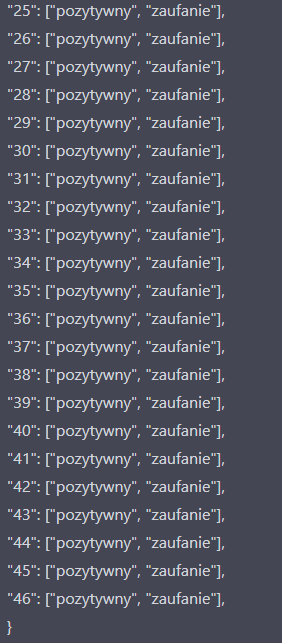

In [ ]:
max_sent_per_example = 10

def enforce_max_sent_per_example_equal(text, text_emotions):
    if text_emotions is not None:
        assert len(text) == len(text_emotions)
    if len(text) > max_sent_per_example and max_sent_per_example > 0:
        i = max_sent_per_example if len(text) > max_sent_per_example else len(text)
        l1 = enforce_max_sent_per_example(
                text[:i], None if text_emotions is None else text_emotions[:i])
        l2 = enforce_max_sent_per_example(
                text[i:], None if text_emotions is None else text_emotions[i:])
        return l1 + l2
    else:
        return [(text, text_emotions)]

def enforce_max_sent_per_example(text, text_emotions):
    if text_emotions is not None:
        assert len(text) == len(text_emotions)
    if len(text) > max_sent_per_example and max_sent_per_example > 0:
        i = len(text) // 2
        l1 = enforce_max_sent_per_example(
                text[:i], None if text_emotions is None else text_emotions[:i])
        l2 = enforce_max_sent_per_example(
                text[i:], None if text_emotions is None else text_emotions[i:])
        return l1 + l2
    else:
        return [(text, text_emotions)]

In [ ]:
aggregate_df = pd.DataFrame(columns=['text', 'emotions'])
sentences = []
emotions = []
for row in test_df.iterrows():
    sentence = str(row[1].iloc[0])
    if sentence == '#' * len(sentence):
        for sentences_loop, labels_loop in enforce_max_sent_per_example_equal(sentences, emotions):
            aggregate_df = pd.concat([aggregate_df, pd.DataFrame({'text': [sentences_loop], 'emotions': [labels_loop]})])
        sentences = []
        emotions = []
    else:
        sentences.append(sentence)
        emotions.append(row[1].iloc[1:].values.tolist())
    

In [ ]:
emotion_labels = ['radość', 'zaufanie', 'przeczuwanie', 'zdziwienie', 'strach', 'smutek', 'wstręt', 'gniew', 'pozytywny', 'negatywny', 'neutralny']

In [ ]:
beining_of_the_prompt = 'Oceń jakie emocje mógł odczuwać autor treści opinii w poszczególnych zdaniach. Do każdego ze zdań przyporządkuj minimum jedną etykietę pozytywny, negatywny, neutralny. Jeśli przyporządkowana etykieta jest inna etykieta niż tylko neutralny, to przyporządkuj też jak najwięcej, minimum jedną, emocje z listy: radość, zaufanie, przeczuwanie, zdziwienie, strach, smutek, wstręt, gniew. Wynik przedstaw w formacie JSON, gdzie kluczem będzie numer zdania, a wartością lista zawierająca etykiety opisujące te zdania. Zdania są podane w takiej kolejności, jak występowały w opinii.'

In [ ]:
middle_of_the_prompt_zero_shot = ' Oceń emocje autora w każdym z %d zdań następującej opinii:'

def get_row(df):
    emotion_labels = ['radość', 'zaufanie', 'przeczuwanie', 'zdziwienie', 'strach', 'smutek', 'wstręt', 'gniew', 'pozytywny', 'negatywny', 'neutralny']
    for row_index, row in df.iterrows():
        list_of_sentences = row.text
        prompt = beining_of_the_prompt + middle_of_the_prompt_zero_shot % len(list_of_sentences) + '\n'
        for i, text in enumerate(list_of_sentences[:-1]):
            prompt += str(i + 1) + '. ' + text + '\n'
        prompt += str(len(list_of_sentences)) + '. ' + list_of_sentences[-1]
        emotions = [list(compress(emotion_labels, e)) for e in row.emotions]
        yield prompt, emotions

In [ ]:
columns = ['prompt', 'annotation', 'taken', 'chatgpt']
rows = []

for prompt, emotions in get_row(aggregate_df):
  rows.append([prompt, emotions, None, None])

new_df = pd.DataFrame(rows, columns=columns)

In [ ]:
new_df.to_csv('clarinemo2.csv', encoding='utf-8', index=False)